In [1]:
import sys
import stlearn as st
st.settings.set_figure_params(dpi=300)
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sys
file = Path("../stimage").resolve()
parent= file.parent
sys.path.append(str(parent))
from PIL import Image
from stimage._utils import gene_plot, Read10X, ReadOldST
from stimage._model import CNN_NB_trainable
from stimage._data_generator import DataGenerator
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from anndata import read_h5ad

In [14]:
def gene_plot(
        adata: AnnData,
        method: str = "CumSum",
        genes: Optional[Union[str, list]] = None,
        threshold: float = None,
        library_id: str = None,
        data_alpha: float = 1.0,
        tissue_alpha: float = 1.0,
        vmin: float = None,
        vmax: float = None,
        cmap: str = "Spectral_r",
        spot_size: Union[float, int] = 6.5,
        show_legend: bool = False,
        show_color_bar: bool = True,
        show_axis: bool = False,
        cropped: bool = True,
        margin: int = 100,
        name: str = None,
        output: str = None,
        copy: bool = False,
) -> Optional[AnnData]:
    """\
    Gene expression plot for sptial transcriptomics data.
    Parameters
    ----------
    adata
        Annotated data matrix.
    library_id
        Library id stored in AnnData.
    method
        Use method to count. We prorive: NaiveMean, NaiveSum, CumSum.
    genes
        Choose a gene or a list of genes.
    threshold
        Threshold to filter genes
    data_alpha
        Opacity of the spot.
    tissue_alpha
        Opacity of the tissue.
    cmap
        Color map to use.
    spot_size
        Size of the spot.
    show_color_bar
        Show color bar or not.
    show_axis
        Show axis or not.
    show_legend
        Show legend or not.
    show_trajectory
        Show the spatial trajectory or not. It requires stlearn.spatial.trajectory.pseudotimespace.
    show_subcluster
        Show subcluster or not. It requires stlearn.spatial.trajectory.global_level.
    name
        Name of the output figure file.
    output
        Save the figure as file or not.
    copy
        Return a copy instead of writing to adata.
    Returns
    -------
    Nothing
    """

    # plt.rcParams['figure.dpi'] = dpi

    if type(genes) == str:
        genes = [genes]
    colors = _gene_plot(adata, method, genes)

    if threshold is not None:
        colors = colors[colors > threshold]

    index_filter = colors.index

    filter_obs = adata.obs.loc[index_filter]

    imagecol = filter_obs["imagecol"]
    imagerow = filter_obs["imagerow"]

    # Option for turning off showing figure
    plt.ioff()

    # Initialize matplotlib
    fig, a = plt.subplots()
    if vmin:
        vmin = vmin
    else:
        vmin = min(colors)
    if vmax:
        vmax = vmax
    else:
        vmax = max(colors)
    # Plot scatter plot based on pixel of spots
    plot = a.scatter(imagecol, imagerow, edgecolor="none", alpha=data_alpha, s=spot_size, marker="o",
                     vmin=vmin, vmax=vmax, cmap=plt.get_cmap(cmap), c=colors)

    if show_color_bar:
        cb = plt.colorbar(plot, cax=fig.add_axes(
            [0.9, 0.3, 0.03, 0.38]), cmap=cmap)
        cb.outline.set_visible(False)

    if not show_axis:
        a.axis('off')

    if library_id is None:
        library_id = list(adata.uns["spatial"].keys())[0]

    image = adata.uns["spatial"][library_id]["images"][adata.uns["spatial"][library_id]["use_quality"]]
    # Overlay the tissue image
    a.imshow(image, alpha=tissue_alpha, zorder=-1, )

    if cropped:
        imagecol = adata.obs["imagecol"]
        imagerow = adata.obs["imagerow"]

        a.set_xlim(imagecol.min() - margin,
                   imagecol.max() + margin)

        a.set_ylim(imagerow.min() - margin,
                   imagerow.max() + margin)

        a.set_ylim(a.get_ylim()[::-1])

    if name is None:
        name = method
    if output is not None:
        fig.savefig(output + "/" + name, dpi=plt.figure().dpi,
                    bbox_inches='tight', pad_inches=0)

    plt.show()


def _gene_plot(adata, method, genes):
    # Gene plot option

    if len(genes) == 0:
        raise ValueError('Genes shoule be provided, please input genes')

    elif len(genes) == 1:

        if genes[0] not in adata.var.index:
            raise ValueError(
                genes[0] + ' is not exist in the data, please try another gene')

        colors = adata[:, genes].to_df().iloc[:, -1]

        return colors
    else:

        for gene in genes:
            if gene not in adata.var.index:
                genes.remove(gene)
                warnings.warn("We removed " + gene +
                              " because they not exist in the data")

            if len(genes) == 0:
                raise ValueError(
                    'All provided genes are not exist in the data')

        count_gene = adata[:, genes].to_df()

        if method is None:
            raise ValueError(
                'Please provide method to combine genes by NaiveMean/NaiveSum/CumSum')

        if method == "NaiveMean":
            present_genes = (count_gene > 0).sum(axis=1) / len(genes)

            count_gene = (count_gene.mean(axis=1)) * present_genes
        elif method == "NaiveSum":
            present_genes = (count_gene > 0).sum(axis=1) / len(genes)

            count_gene = (count_gene.sum(axis=1)) * present_genes

        elif method == "CumSum":
            count_gene = count_gene.cumsum(axis=1).iloc[:, -1]

        colors = count_gene

        return colors
from typing import Optional, Union
from anndata import AnnData
from PIL import Image
from pathlib import Path

# Test progress bar
from tqdm import tqdm
import numpy as np
import os


def tiling(
    adata: AnnData,
    out_path: Union[Path, str] = "./tiling",
    library_id: str = None,
    crop_size: int = 40,
    target_size: int = 299,
    verbose: bool = False,
    copy: bool = False,
) -> Optional[AnnData]:
    """\
    Tiling H&E images to small tiles based on spot spatial location

    Parameters
    ----------
    adata
        Annotated data matrix.
    out_path
        Path to save spot image tiles
    library_id
        Library id stored in AnnData.
    crop_size
        Size of tiles
    verbose
        Verbose output
    copy
        Return a copy instead of writing to adata.
    target_size
        Input size for convolutional neuron network
    Returns
    -------
    Depending on `copy`, returns or updates `adata` with the following fields.
    **tile_path** : `adata.obs` field
        Saved path for each spot image tiles
    """

    if library_id is None:
        library_id = list(adata.uns["spatial"].keys())[0]

    # Check the exist of out_path
    if not os.path.isdir(out_path):
        os.mkdir(out_path)

    image = adata.uns["spatial"][library_id]["images"][adata.uns["spatial"]["use_quality"]]
    if image.dtype == np.float32 or image.dtype == np.float64:
        image = (image * 255).astype(np.uint8)
    img_pillow = Image.fromarray(image)
    tile_names = []

    with tqdm(
        total=len(adata),
        desc="Tiling image",
        bar_format="{l_bar}{bar} [ time left: {remaining} ]",
    ) as pbar:
        for imagerow, imagecol in zip(adata.obs["imagerow"], adata.obs["imagecol"]):
            imagerow_down = imagerow - crop_size / 2
            imagerow_up = imagerow + crop_size / 2
            imagecol_left = imagecol - crop_size / 2
            imagecol_right = imagecol + crop_size / 2
            tile = img_pillow.crop(
                (imagecol_left, imagerow_down, imagecol_right, imagerow_up)
            )
            #tile.thumbnail((target_size, target_size), Image.ANTIALIAS)
            tile = tile.resize((target_size, target_size))
            tile_name = library_id + "-" + str(imagecol) + "-" + str(imagerow) + "-" + str(crop_size)
            out_tile = Path(out_path) / (tile_name + ".jpeg")
            tile_names.append(str(out_tile))
            if verbose:
                print(
                    "generate tile at location ({}, {})".format(
                        str(imagecol), str(imagerow)
                    )
                )
            tile.save(out_tile, "JPEG")

            pbar.update(1)

    adata.obs["tile_path"] = tile_names
    return adata if copy else None


In [3]:
BASE_PATH=Path("/clusterdata/uqxtan9/Xiao/STimage/"
                "dataset/breast_cancer_oldST_STNet")
TILING_PATH= Path("/tmp/tile")
TILING_PATH.mkdir(parents=True, exist_ok=True)

In [4]:
meta = pd.read_csv(BASE_PATH / "metadata.csv")

In [5]:
meta

,type,patient,replicate,count_matrix,histology_image,spot_coordinates
0,HER2_luminal,BC23287,C1,BC23287_C1_stdata.tsv.gz,HE_BT23287_C1.jpg,spots_BT23287_C1.csv.gz
1,HER2_luminal,BC23287,C2,BC23287_C2_stdata.tsv.gz,HE_BT23287_C2.jpg,spots_BT23287_C2.csv.gz
2,HER2_luminal,BC23287,D1,BC23287_D1_stdata.tsv.gz,HE_BT23287_D1.jpg,spots_BT23287_D1.csv.gz
3,HER2_luminal,BC23450,D2,BC23450_D2_stdata.tsv.gz,HE_BT23450_D2.jpg,spots_BT23450_D2.csv.gz
4,HER2_luminal,BC23450,E1,BC23450_E1_stdata.tsv.gz,HE_BT23450_E1.jpg,spots_BT23450_E1.csv.gz
...,...,...,...,...,...,...
63,TNBC,BC23377,C2,BC23377_C2_stdata.tsv.gz,HE_BT23377_C2.jpg,spots_BT23377_C2.csv.gz
64,TNBC,BC23377,D1,BC23377_D1_stdata.tsv.gz,HE_BT23377_D1.jpg,spots_BT23377_D1.csv.gz
65,TNBC,BC23803,D2,BC23803_D2_stdata.tsv.gz,HE_BC23803_D2.jpg,spots_BC23803_D2.csv.gz
66,TNBC,BC23803,E1,BC23803_E1_stdata.tsv.gz,HE_BC23803_E1.jpg,spots_BC23803_E1.csv.gz


In [6]:
cm_path_list = []
spot_path_list = []
img_path_list = []
Sample_list = []
for index,row in meta.iterrows():
    cm_path = BASE_PATH / "stdata" / row["count_matrix"].split(".gz")[0]
    cm_path_list.append(cm_path)
    spot_path = BASE_PATH / "spotinfo" / row["spot_coordinates"].split(".gz")[0]
    spot_path_list.append(spot_path)
    img_path = BASE_PATH / "HEimage" / row["histology_image"]
    img_path_list.append(img_path)
    Sample = row["patient"] +"_"+ row["replicate"]
    Sample_list.append(Sample)
    
df = pd.DataFrame({
    "sample" : Sample_list,
    "count_matrix" : cm_path_list,
    "spot_coordinates" : spot_path_list,
    "histology_image" : img_path_list
})

In [7]:
df

,sample,count_matrix,spot_coordinates,histology_image
0,BC23287_C1,/clusterdata/uqxtan9/Xiao/STimage/dataset/brea...,/clusterdata/uqxtan9/Xiao/STimage/dataset/brea...,/clusterdata/uqxtan9/Xiao/STimage/dataset/brea...
1,BC23287_C2,/clusterdata/uqxtan9/Xiao/STimage/dataset/brea...,/clusterdata/uqxtan9/Xiao/STimage/dataset/brea...,/clusterdata/uqxtan9/Xiao/STimage/dataset/brea...
2,BC23287_D1,/clusterdata/uqxtan9/Xiao/STimage/dataset/brea...,/clusterdata/uqxtan9/Xiao/STimage/dataset/brea...,/clusterdata/uqxtan9/Xiao/STimage/dataset/brea...
3,BC23450_D2,/clusterdata/uqxtan9/Xiao/STimage/dataset/brea...,/clusterdata/uqxtan9/Xiao/STimage/dataset/brea...,/clusterdata/uqxtan9/Xiao/STimage/dataset/brea...
4,BC23450_E1,/clusterdata/uqxtan9/Xiao/STimage/dataset/brea...,/clusterdata/uqxtan9/Xiao/STimage/dataset/brea...,/clusterdata/uqxtan9/Xiao/STimage/dataset/brea...
...,...,...,...,...
63,BC23377_C2,/clusterdata/uqxtan9/Xiao/STimage/dataset/brea...,/clusterdata/uqxtan9/Xiao/STimage/dataset/brea...,/clusterdata/uqxtan9/Xiao/STimage/dataset/brea...
64,BC23377_D1,/clusterdata/uqxtan9/Xiao/STimage/dataset/brea...,/clusterdata/uqxtan9/Xiao/STimage/dataset/brea...,/clusterdata/uqxtan9/Xiao/STimage/dataset/brea...
65,BC23803_D2,/clusterdata/uqxtan9/Xiao/STimage/dataset/brea...,/clusterdata/uqxtan9/Xiao/STimage/dataset/brea...,/clusterdata/uqxtan9/Xiao/STimage/dataset/brea...
66,BC23803_E1,/clusterdata/uqxtan9/Xiao/STimage/dataset/brea...,/clusterdata/uqxtan9/Xiao/STimage/dataset/brea...,/clusterdata/uqxtan9/Xiao/STimage/dataset/brea...


In [8]:
df.to_csv(BASE_PATH / "dataset.csv")

In [8]:
adata_list = []
for index,row in meta.iterrows():
    cm_path = BASE_PATH / "stdata" / row["count_matrix"].split(".gz")[0]
    spot_path = BASE_PATH / "spotinfo" / row["spot_coordinates"].split(".gz")[0]
    img_path = BASE_PATH / "HEimage" / row["histology_image"]
    Sample = row["patient"] +"_"+ row["replicate"]
    adata = st.read.file_table(cm_path)
    spot_df = pd.read_csv(spot_path,index_col=0)
    comm_index = pd.Series(list(set(spot_df.index).intersection(set(adata.obs_names))))
    adata = adata[comm_index]
    adata.obs["imagecol"] = spot_df["X"]
    adata.obs["imagerow"] = spot_df["Y"]
    st.add.image(adata, img_path, library_id=Sample)
    adata.obs["type"] = row["type"]
    st.pp.log1p(adata)
    tiling(adata, out_path=TILING_PATH, crop_size=299)
    adata_list.append(adata)

Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.
Tiling image:   0%|           [ time left: ? ]

Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]
Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]


In [11]:
from pathlib import Path, PurePath
from typing import Optional, Union
from anndata import AnnData
import numpy as np
from PIL import Image
import pandas as pd
import stlearn


def ReadOldST(
    count_matrix_file: Union[str, Path] = None,
    spatial_file: Union[str, Path] = None,
    image_file: Union[str, Path] = None,
    library_id: str = "OldST",
    scale: float = 1.0,
    quality: str = "hires",
    spot_diameter_fullres: float = 50,
) -> AnnData:

    """\
    Read Old Spatial Transcriptomics data
    Parameters
    ----------
    count_matrix_file
        Path to count matrix file.
    spatial_file
        Path to spatial location file.
    image_file
        Path to the tissue image file
    library_id
        Identifier for the visium library. Can be modified when concatenating multiple adata objects.
    scale
        Set scale factor.
    quality
        Set quality that convert to stlearn to use. Store in anndata.obs['imagecol' & 'imagerow']
    spot_diameter_fullres
        Diameter of spot in full resolution
    Returns
    -------
    AnnData
    """

    adata = scanpy.read_text(count_matrix_file)
    spot_df = pd.read_csv(spot_path, index_col=0)
    comm_index = pd.Series(list(set(spot_df.index).intersection(set(adata.obs_names))))
    adata = adata[comm_index]
    adata.obs["imagecol"] = spot_df["X"]
    adata.obs["imagerow"] = spot_df["Y"]
    stlearn.add.image(
        adata,
        library_id=library_id,
        quality=quality,
        imgpath=image_file,
        scale=scale,
        spot_diameter_fullres=spot_diameter_fullres,
    )

    return adata

In [12]:
import scanpy
adata_list = []
for index, row in meta.iterrows():
    cm_path = BASE_PATH / "stdata" / row["count_matrix"].split(".gz")[0]
    spot_path = BASE_PATH / "spotinfo" / row["spot_coordinates"].split(".gz")[0]
    img_path = BASE_PATH / "HEimage" / row["histology_image"]
    Sample = row["patient"] +"_"+ row["replicate"]
    adata = ReadOldST(count_matrix_file=cm_path,
                                  spatial_file=spot_path,
                                  image_file=img_path,
                                  library_id=Sample,
                                  quality="fulres")
    adata_list.append(adata)

Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


Trying to set attribute `.obs` of view, copying.


Added tissue image to the object!


In [10]:
ems_df = pd.read_csv("/clusterdata/uqxtan9/Xiao/STimage/dataset/ensembl.tsv", sep="\t")

In [9]:
adata_all.var["mean_expression"] = np.mean(adata_all.X, axis=0)

In [27]:
a = adata_all.var_names.intersection(ems_df["Ensembl ID(supplied by Ensembl)"])

In [19]:
a = pd.Index(ems_df["Ensembl ID(supplied by Ensembl)"]).intersection(adata_all.var_names)

In [20]:
b = ems_df["Approved symbol"][ems_df["Ensembl ID(supplied by Ensembl)"].isin(a)]

In [24]:
var_dic = dict(zip(ems_df["Ensembl ID(supplied by Ensembl)"],ems_df["Approved symbol"]))

In [25]:
ems_df

,HGNC ID,Approved symbol,Approved name,Ensembl ID(supplied by Ensembl)
0,HGNC:5,A1BG,alpha-1-B glycoprotein,ENSG00000121410
1,HGNC:37133,A1BG-AS1,A1BG antisense RNA 1,ENSG00000268895
2,HGNC:24086,A1CF,APOBEC1 complementation factor,ENSG00000148584
3,HGNC:6,A1S9T,"symbol withdrawn, see [HGNC:12469](/data/gene-...",NaN
4,HGNC:7,A2M,alpha-2-macroglobulin,ENSG00000175899
...,...,...,...,...
47541,HGNC:25820,ZYG11B,"zyg-11 family member B, cell cycle regulator",ENSG00000162378
47542,HGNC:13200,ZYX,zyxin,ENSG00000159840
47543,HGNC:51695,ZYXP1,zyxin pseudogene 1,ENSG00000274572
47544,HGNC:29027,ZZEF1,zinc finger ZZ-type and EF-hand domain contain...,ENSG00000074755


In [26]:
var_dic

{'ENSG00000121410': 'A1BG',
 'ENSG00000268895': 'A1BG-AS1',
 'ENSG00000148584': 'A1CF',
 nan: 'ZWS1',
 'ENSG00000175899': 'A2M',
 'ENSG00000245105': 'A2M-AS1',
 'ENSG00000166535': 'A2ML1',
 'ENSG00000256661': 'A2ML1-AS1',
 'ENSG00000256904': 'A2ML1-AS2',
 'ENSG00000256069': 'A2MP1',
 'ENSG00000184389': 'A3GALT2',
 'ENSG00000128274': 'A4GALT',
 'ENSG00000118017': 'A4GNT',
 'ENSG00000094914': 'AAAS',
 'ENSG00000081760': 'AACS',
 'ENSG00000250420': 'AACSP1',
 'ENSG00000114771': 'AADAC',
 'ENSG00000197953': 'AADACL2',
 'ENSG00000242908': 'AADACL2-AS1',
 'ENSG00000188984': 'AADACL3',
 'ENSG00000204518': 'AADACL4',
 'ENSG00000240602': 'AADACP1',
 'ENSG00000109576': 'AADAT',
 'ENSG00000103591': 'AAGAB',
 'ENSG00000115977': 'AAK1',
 'ENSG00000087884': 'AAMDC',
 'ENSG00000127837': 'AAMP',
 'ENSG00000129673': 'AANAT',
 'ENSG00000131043': 'AAR2',
 'ENSG00000205002': 'AARD',
 'ENSG00000090861': 'AARS1',
 'ENSG00000249038': 'AARS1P1',
 'ENSG00000124608': 'AARS2',
 'ENSG00000266967': 'AARSD1',
 'ENS

In [28]:
adata_all = adata_all[:,a].copy()

/scratch/imb/Xiao/.conda/envs/stimage/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [29]:
adata_all.var_names = adata_all.var_names.map(var_dic)


In [30]:
adata_all

AnnData object with n_obs × n_vars = 30655 × 11341
    obs: 'imagecol', 'imagerow', 'type', 'tile_path', 'library_id'
    uns: 'spatial', 'log1p'

In [32]:
adata_all.to_df()

,TSPAN6,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,STPG1,...,MRM1,GOLGA6L10,MRPL45,WASH9P,GATD3B,LINC01943,PAGR1,LINC01176,EBLN3P,ADORA3
5x27-BC23287_C1,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.693147,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
2x25-BC23287_C1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.693147,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
11x31-BC23287_C1,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
9x21-BC23287_C1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.098612,0.0,0.0,0.0,...,1.098612,0.0,0.693147,1.098612,0.0,0.000000,0.0,0.0,0.000000,0.0
6x21-BC23287_C1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.693147,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19x25-BC23803_E2,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,0.693147,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
24x19-BC23803_E2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
25x27-BC23803_E2,0.000000,0.000000,0.693147,0.000000,0.693147,0.000000,1.098612,0.0,0.0,0.0,...,0.000000,0.0,0.000000,1.098612,0.0,0.000000,0.0,0.0,0.000000,0.0
26x16-BC23803_E2,0.000000,0.693147,0.693147,0.693147,0.693147,1.098612,1.098612,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.693147,0.0,0.000000,0.0,0.0,1.098612,0.0


In [58]:
adata_all.write(BASE_PATH / "all_adata.h5ad")

... storing 'type' as categorical


In [7]:
adata_all = read_h5ad(BASE_PATH / "all_adata.h5ad")

In [30]:
top_250_genes = adata_all.var["mean_expression"
                             ].sort_values(ascending=False
                                            ).index[0:50]

In [45]:
gene_list=["TTLL12", "COX6C", "MALAT1"]

In [46]:
for i in gene_list:
    adata_all_50_ = adata_all[:,i].copy()

In [47]:

adata_all_50 = adata_all[:,gene_list].copy()

In [48]:
adata_all_50.X

array([[0.6931472, 0.       , 2.3025851],
       [1.3862944, 0.       , 0.6931472],
       [0.6931472, 0.       , 0.6931472],
       ...,
       [1.9459102, 0.       , 0.       ],
       [0.       , 0.       , 0.       ],
       [1.0986123, 0.       , 0.       ]], dtype=float32)

In [49]:
import seaborn as sns

<AxesSubplot:>

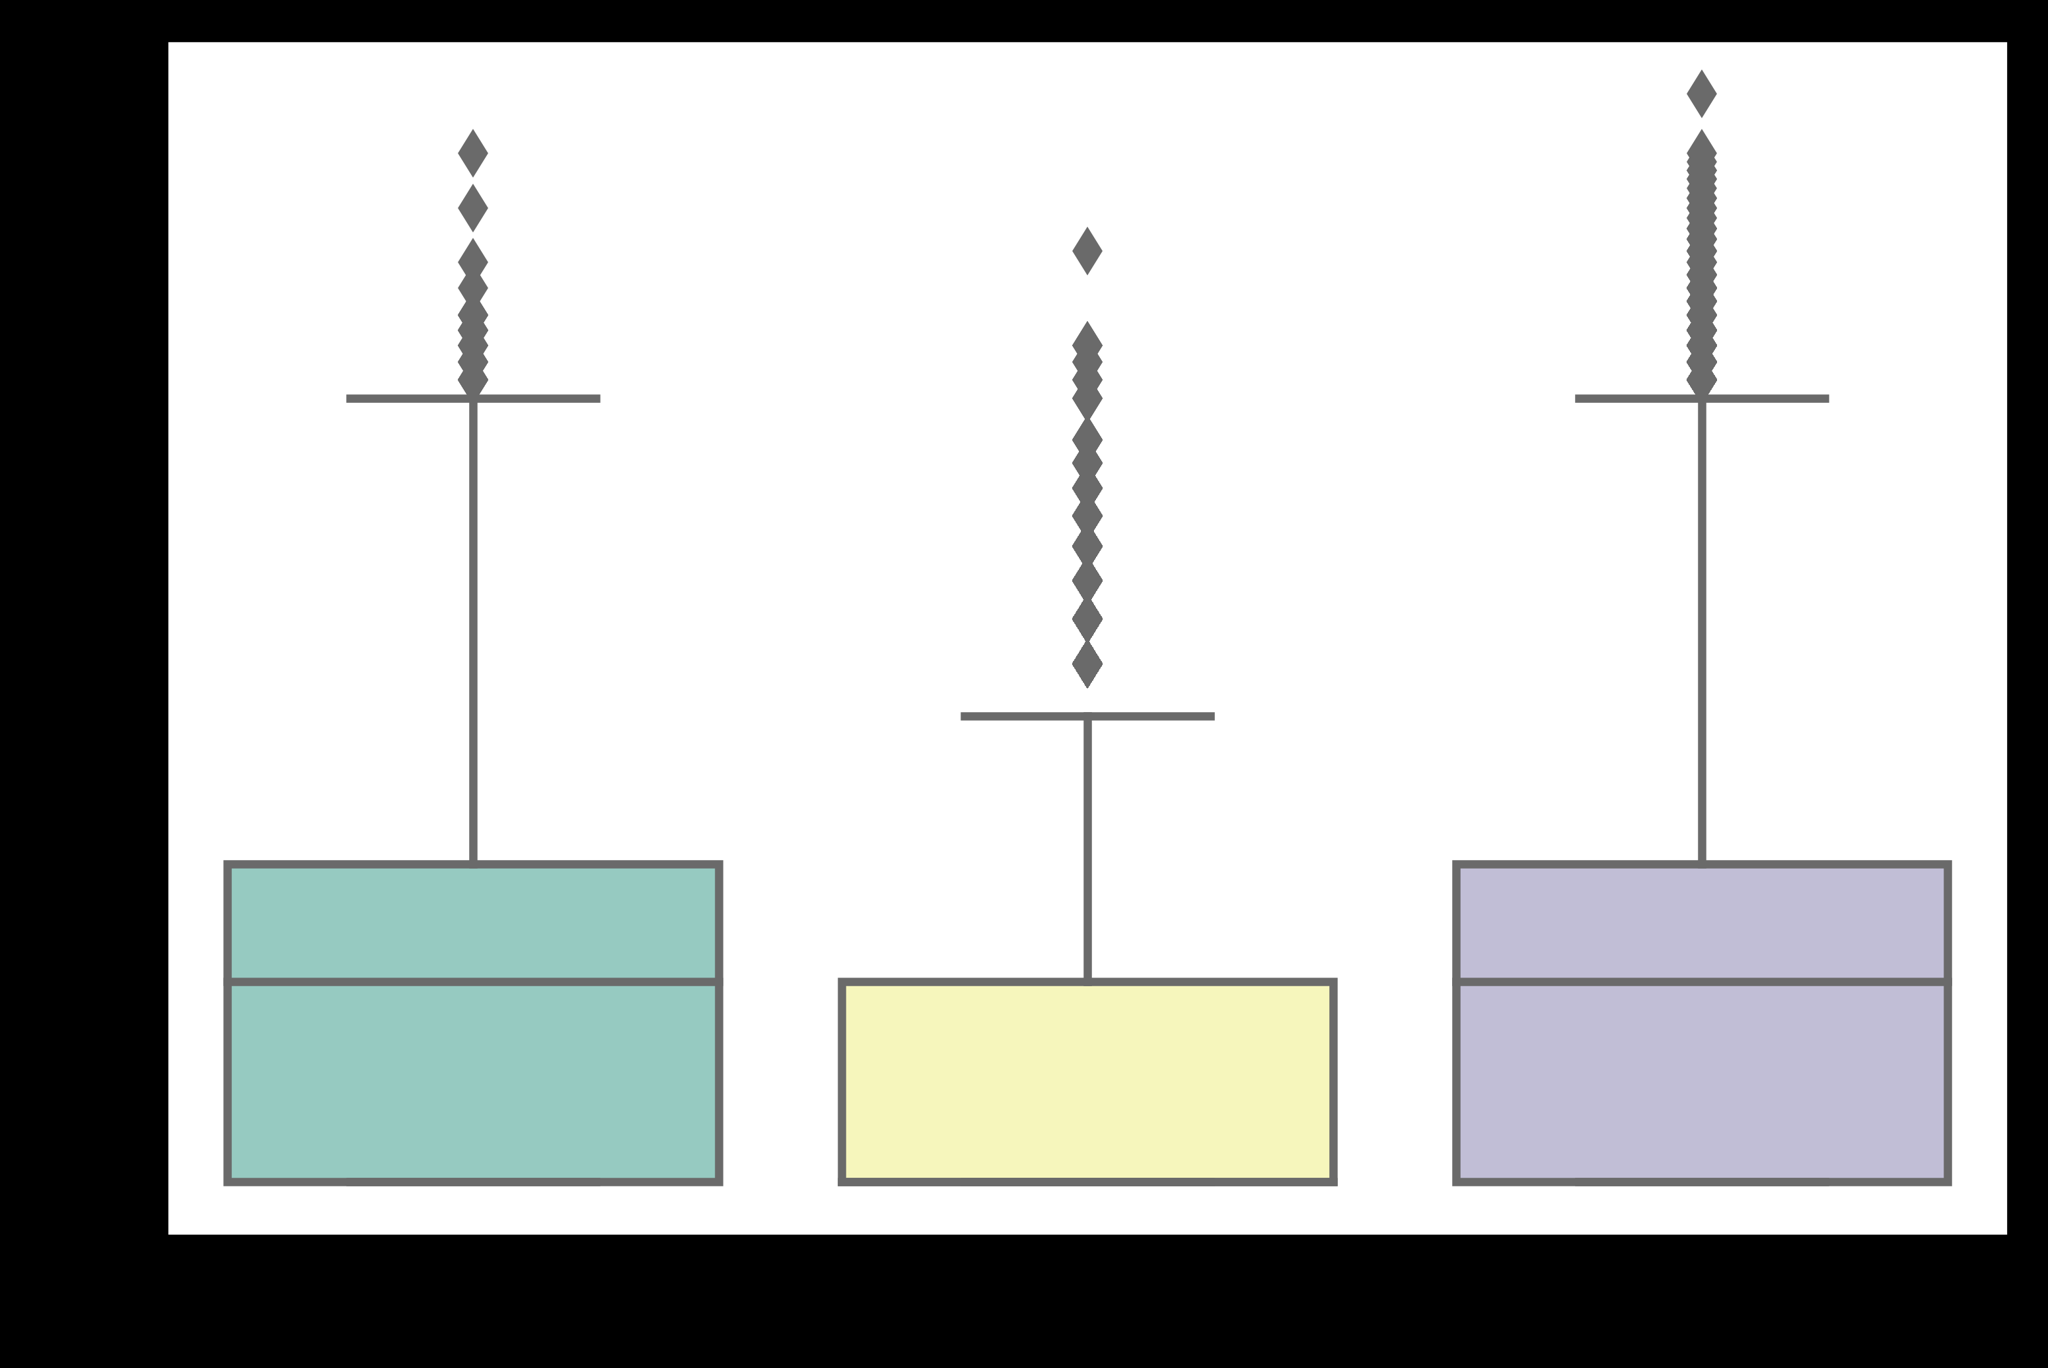

In [50]:
sns.boxplot(data=adata_all_50.to_df(), palette="Set3")

In [12]:
adata_all = adata_all[:,top_250_genes].copy()

In [22]:
tumor_genes = ["PABPC1", "GNAS", "HSP90AB1", "TFF3", 
               "ATP1A1", "COX6C", "B2M", "FASN", 
               "ACTG1", "HLA-B"]

In [8]:
adata_all = adata_all[:,tumor_genes].copy()

KeyError: "Values ['PABPC1', 'GNAS', 'HSP90AB1', 'TFF3', 'ATP1A1', 'COX6C', 'B2M', 'FASN', 'ACTG1', 'HLA-B'], from ['PABPC1', 'GNAS', 'HSP90AB1', 'TFF3', 'ATP1A1', 'COX6C', 'B2M', 'FASN', 'ACTG1', 'HLA-B'], are not valid obs/ var names or indices."

In [13]:
All_sample = pd.Series(adata_all.obs["library_id"].unique())
training_sample = All_sample.sample(frac=0.7, random_state=1)
training_index = All_sample.index.isin(training_sample.index)
test_Sample = All_sample[~training_index].copy()

In [14]:
train_adata = adata_all[adata_all.obs["library_id"].isin(training_sample)].copy()
test_adata = adata_all[adata_all.obs["library_id"].isin(test_Sample)].copy()

In [15]:
train_adata

AnnData object with n_obs × n_vars = 22005 × 250
    obs: 'imagecol', 'imagerow', 'type', 'tile_path', 'library_id'
    var: 'mean_expression'
    uns: 'spatial'

In [16]:
test_adata

AnnData object with n_obs × n_vars = 8650 × 250
    obs: 'imagecol', 'imagerow', 'type', 'tile_path', 'library_id'
    var: 'mean_expression'
    uns: 'spatial'

In [18]:
comm_genes = top_250_genes
n_genes = len(comm_genes)
train_gen = tf.data.Dataset.from_generator(
            lambda:DataGenerator(adata=train_adata, 
                          genes=comm_genes, aug=True),
            output_types=(tf.float32, tuple([tf.float32]*n_genes)), 
            output_shapes=([299,299,3], tuple([1]*n_genes))
)
train_gen_ = train_gen.shuffle(buffer_size=500).batch(128).repeat(3).cache().prefetch(tf.data.experimental.AUTOTUNE)

test_gen = tf.data.Dataset.from_generator(
            lambda:DataGenerator(adata=test_adata, 
                          genes=comm_genes), 
            output_types=(tf.float32, tuple([tf.float32]*n_genes)), 
            output_shapes=([299,299,3], tuple([1]*n_genes))
)
test_gen_ = test_gen.batch(1)




In [19]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input as preprocess_vgg16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input as preprocess_resnet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, concatenate, Dropout, Lambda, Concatenate
from tensorflow.keras.models import Model
import tensorflow_probability as tfp
tf.compat.v1.enable_eager_execution()
tfd = tfp.distributions
tfb = tfp.bijectors
import six
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils.tf_utils import is_tensor_or_variable


def negative_binomial_layer(x):
    """
    Lambda function for generating negative binomial parameters
    n and p from a Dense(2) output.
    Assumes tensorflow 2 backend.

    Usage
    -----
    outputs = Dense(2)(final_layer)
    distribution_outputs = Lambda(negative_binomial_layer)(outputs)

    Parameters
    ----------
    x : tf.Tensor
        output tensor of Dense layer

    Returns
    -------
    out_tensor : tf.Tensor

    """

    # Get the number of dimensions of the input
    num_dims = len(x.get_shape())

    # Separate the parameters
    n, p = tf.unstack(x, num=2, axis=-1)

    # Add one dimension to make the right shape
    n = tf.expand_dims(n, -1)
    p = tf.expand_dims(p, -1)

    # Apply a softplus to make positive
    n = tf.keras.activations.softplus(n)

    # Apply a sigmoid activation to bound between 0 and 1
    p = tf.keras.activations.sigmoid(p)

    # Join back together again
    out_tensor = tf.concat((n, p), axis=num_dims - 1)

    return out_tensor


def negative_binomial_loss(y_true, y_pred):
    """
    Negative binomial loss function.
    Assumes tensorflow backend.
    
    Parameters
    ----------
    y_true : tf.Tensor
        Ground truth values of predicted variable.
    y_pred : tf.Tensor
        n and p values of predicted distribution.

    Returns
    -------
    nll : tf.Tensor
        Negative log likelihood.
    """

    # Separate the parameters
    n, p = tf.unstack(y_pred, num=2, axis=-1)

    # Add one dimension to make the right shape
    n = tf.expand_dims(n, -1)
    p = tf.expand_dims(p, -1)

    # Calculate the negative log likelihood
    nll = (
        tf.math.lgamma(n)
        + tf.math.lgamma(y_true + 1)
        - tf.math.lgamma(n + y_true)
        - n * tf.math.log(p)
        - y_true * tf.math.log(1 - p)
        )

    return nll



def resnet_NB(tile_shape, n_genes):
    tile_input = Input(shape=tile_shape, name = "tile_input")
    resnet_base = ResNet50(input_tensor=tile_input, weights='imagenet', include_top=False)
#     stage_5_start = resnet_base.get_layer("conv5_block1_1_conv")
#     for i in range(resnet_base.layers.index(stage_5_start)):
#         resnet_base.layers[i].trainable = False
    
    for i in resnet_base.layers:
        i.trainable = False
    cnn = resnet_base.output
    cnn = GlobalAveragePooling2D()(cnn)
#     cnn = Dropout(0.5)(cnn)
#     cnn = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01),
#                 activity_regularizer=tf.keras.regularizers.l2(0.01))(cnn)
    # cnn = Dense(256, activation='relu')(cnn)
    output_layers = []
    for i in range(n_genes):
        output = Dense(2)(cnn)
        output_layers.append(Lambda(negative_binomial_layer, name="gene_{}".format(i))(output))
    
    model = Model(inputs=tile_input, outputs=output_layers)
#     losses={}
#     for i in range(8):
#         losses["gene_{}".format(i)] = negative_binomial_loss(i)
#     optimizer = tf.keras.optimizers.RMSprop(0.001)
    optimizer = tf.keras.optimizers.Adam(0.0001)
    model.compile(loss=negative_binomial_loss,
                  optimizer=optimizer)    
    return model

In [20]:
class PrinterCallback(tf.keras.callbacks.Callback):

    # def on_train_batch_begin(self, batch, logs=None):
    #     # Do something on begin of training batch

    def on_epoch_end(self, epoch, logs=None):
        print('EPOCH: {}, Train Loss: {}, Val Loss: {}'.format(epoch,
                                                               logs['loss'],
                                                               logs['val_loss']))

    def on_epoch_begin(self, epoch, logs=None):
        print('-'*50)
        print('STARTING EPOCH: {}'.format(epoch))

In [21]:
# model = vgg16_ZINB((299, 299, 3))
model = resnet_NB((299, 299, 3), n_genes)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                            restore_best_weights=True)

In [ ]:
train_history = model.fit(train_gen_,
                          epochs=5,
                          callbacks=[callback, PrinterCallback()],
                          verbose=0
                          )

--------------------------------------------------
STARTING EPOCH: 0


/scratch/imb/Xiao/.conda/envs/stimage/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [26]:
model.load_weights("/clusterdata/uqxtan9/Xiao/STimage/development/Wiener/resnet50_NB_multi_STnet/resnet_nb_100epoch_14040201.h5")


In [27]:
test_predictions = model.predict(test_gen_)

/scratch/imb/Xiao/.conda/envs/stimage/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [28]:
# test_predictions = model.predict(test_gen_)
from scipy.stats import nbinom
y_preds=[]
for i in range(10):
    n = test_predictions[i][:,0]; p = test_predictions[i][:,1]
    y_pred = nbinom.mean(n,p)
    y_preds.append(y_pred)

test_adata.obsm["predicted_gene"] = np.array(y_preds).transpose()

In [36]:
test_adata_ = test_adata.copy()
test_adata_.X = test_adata_.obsm["predicted_gene"]

In [31]:
test_library = test_adata.obs["library_id"].unique()

In [34]:
OUT_PATH = Path("/clusterdata/uqxtan9/Xiao/STimage/development/Wiener/resnet50_NB_multi_STnet/test_results")
OUT_PATH.mkdir(parents=True, exist_ok=True)


In [44]:
# for i, library in enumerate(
#     test_library
# ):
#     for gene in tumor_genes:
#         ad = test_adata_[test_adata_.obs.library_id == library, :].copy()
#         gene_plot(ad, genes=gene, spot_size=60, library_id=library,
#                   output=str(OUT_PATH), name="predict_{}_{}.png".format(library, gene))

In [45]:
# for i, library in enumerate(
#     test_library
# ):
#     for gene in tumor_genes:
#         ad = test_adata[test_adata.obs.library_id == library, :].copy()
#         gene_plot(ad, genes=gene,spot_size=60,
#                   output=str(OUT_PATH), name="GC_{}_{}.png".format(library, gene))

In [48]:
# from scipy import stats
# import seaborn as sns
# import matplotlib.pyplot as plt

# r2_list = []
# for gene in tumor_genes:
#     r2 = stats.pearsonr(test_adata[:,gene], 
#                         test_adata_[:,gene])[0] ** 2
#     r2.append(r2)

In [ ]:
r2_list = []
genes_list = []
sample_list = []
for i, library in enumerate(
    test_library
):
    ad_ = test_adata_[test_adata_.obs.library_id == library, :].copy()
    ad = test_adata[test_adata.obs.library_id == library, :].copy()
    for gene in tumor_genes:
        r2 = stats.pearsonr(ad[:,gene], 
                                ad_[:,gene])[0] ** 2
        r2.append(r2)
        genes_list.append(gene)
        sample_list.append(library)
        print("finished sample: {}".format(library))

In [ ]:
df = pd.DataFrame({"R2": r2_list,
                   "tumor_gene": genes_list,
                   "sample":sample_list})

In [ ]:
df.to_csv(OUT_PATH / "r2.csv")

In [5]:
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

In [6]:
OUT_PATH = Path("/clusterdata/uqxtan9/Xiao/STimage/development/Wiener/resnet50_NB_multi_STnet/test_results")
df = pd.read_csv(OUT_PATH/"r2.csv", index_col=0)

In [8]:
df["r"] = df["R2"]

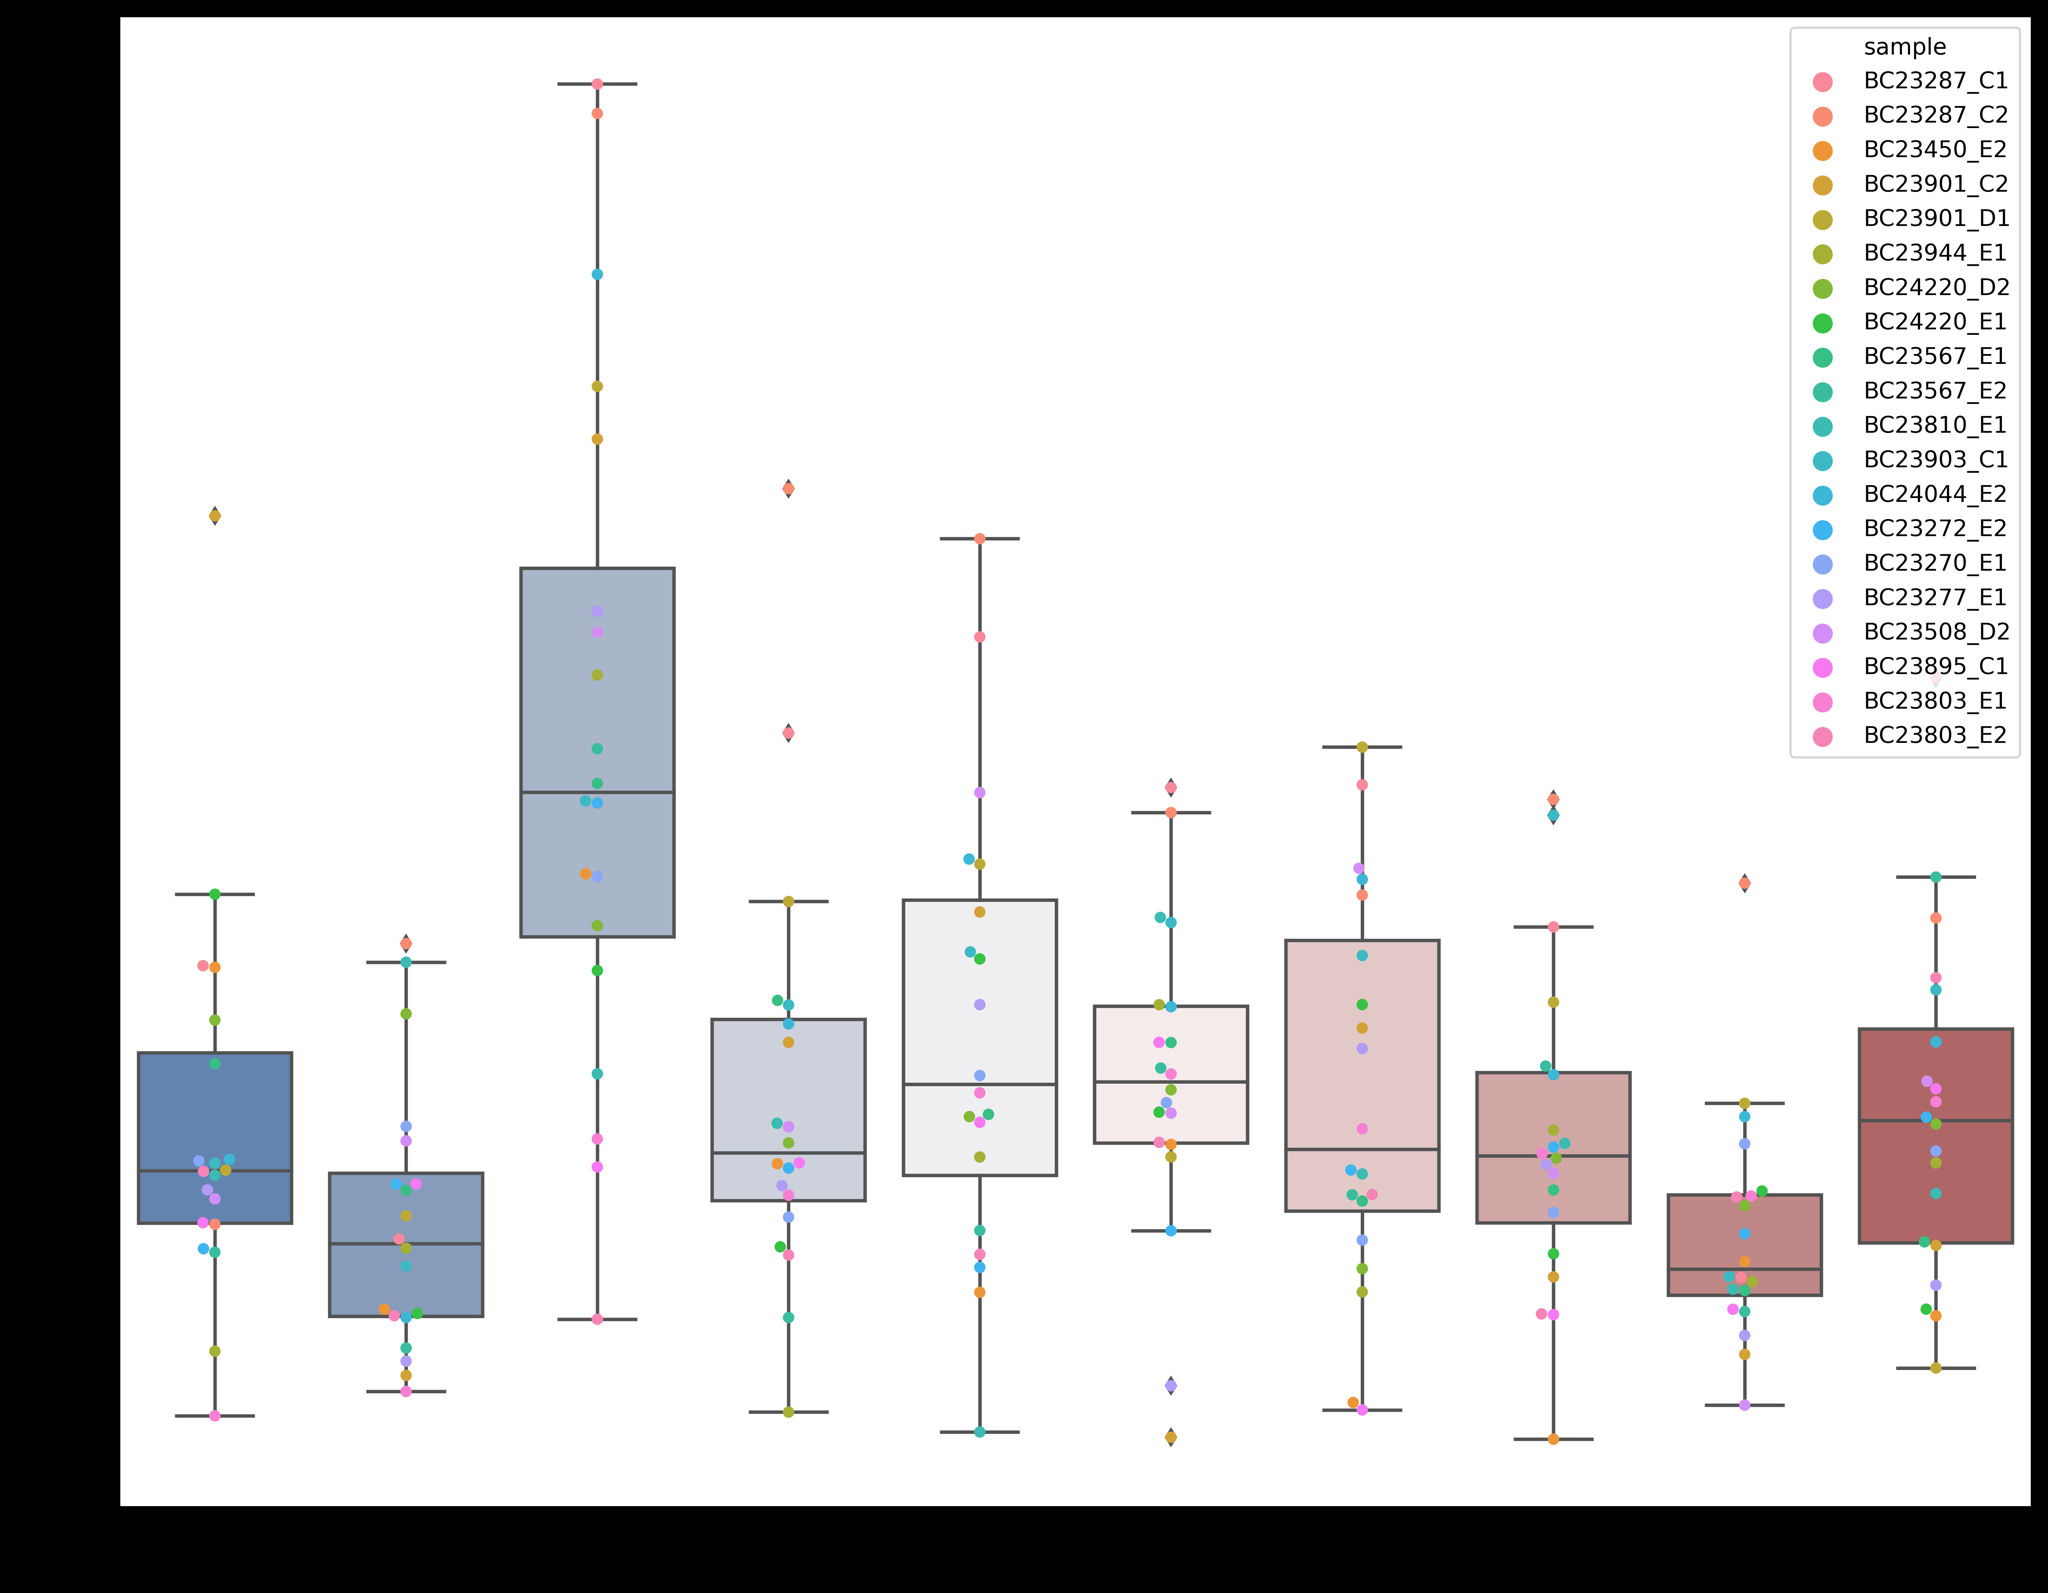

In [36]:
f, ax = plt.subplots(figsize=(15, 12))
sns.boxplot(x="tumor_gene", y="r", data=df, palette="vlag")
sns.swarmplot(x="tumor_gene", y="r", data=df, hue="sample")
plt.show()

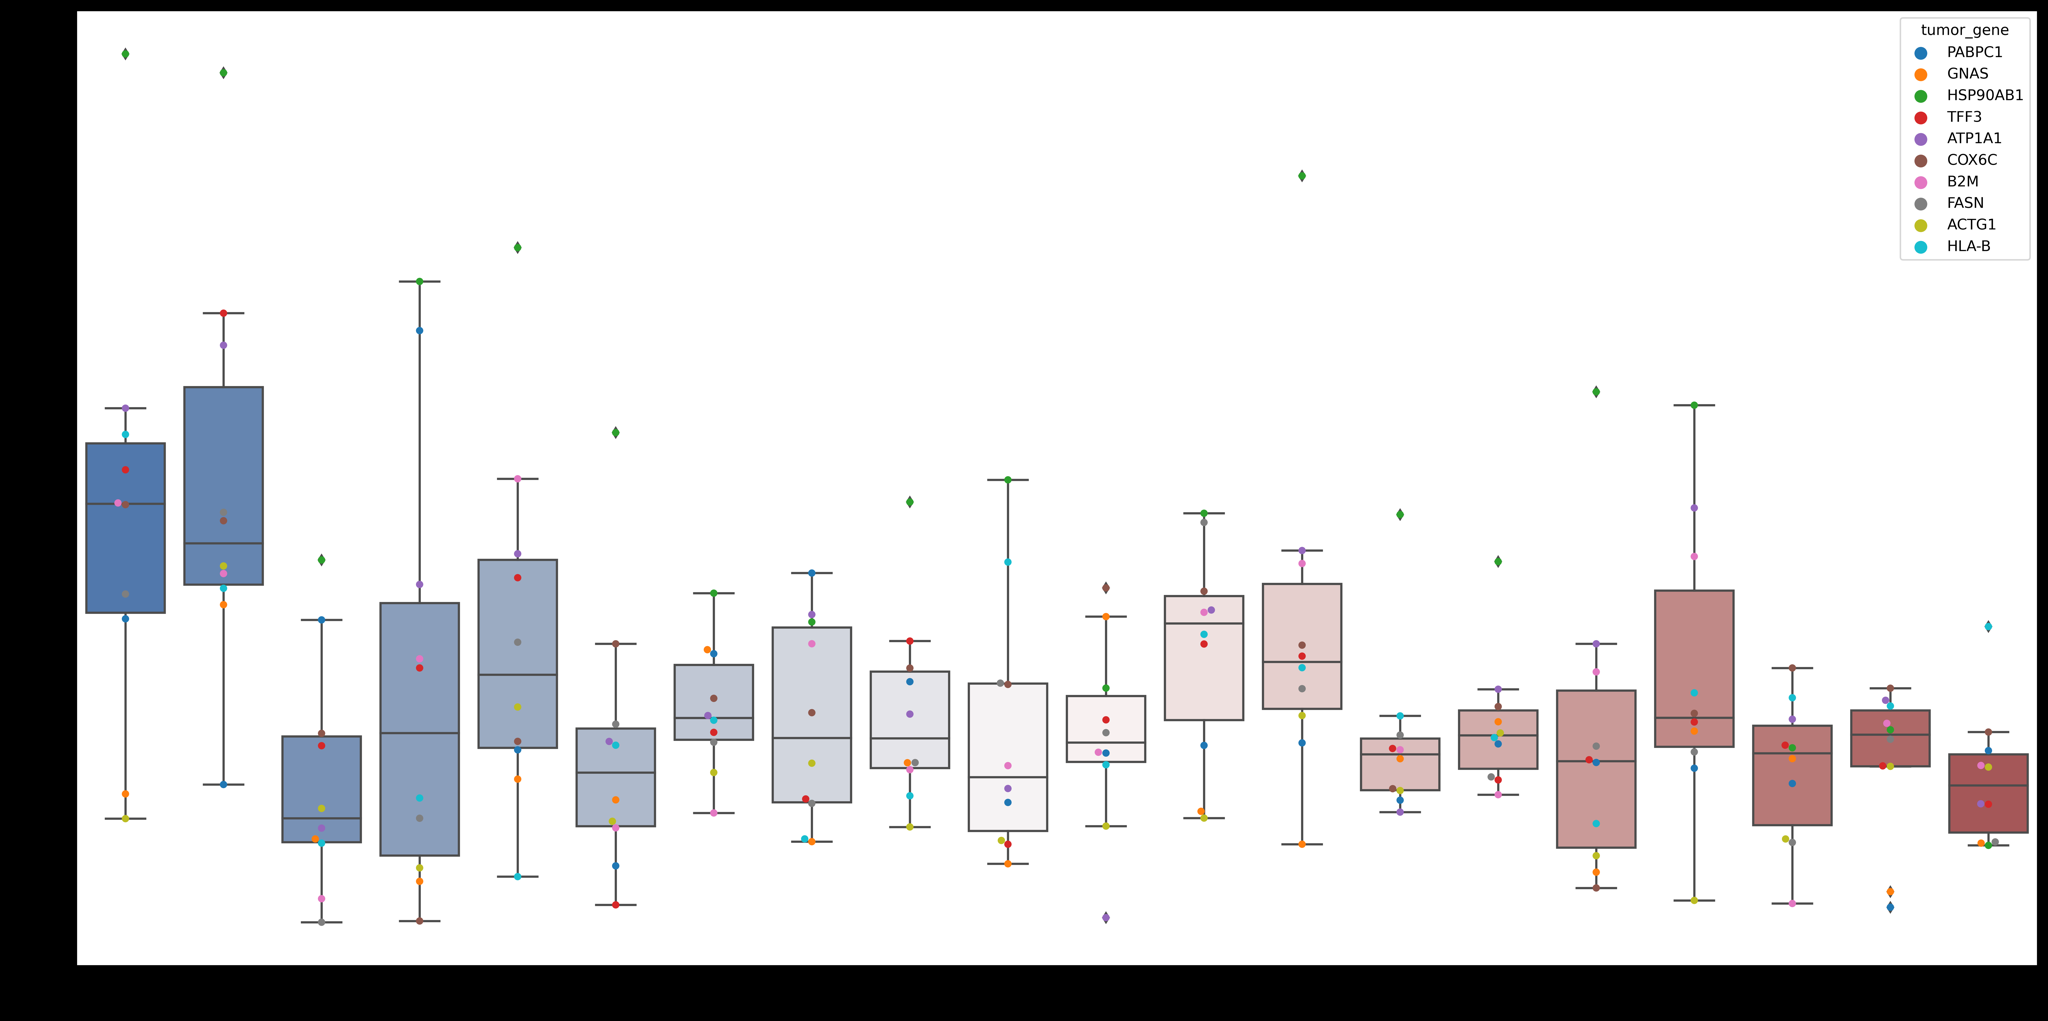

In [37]:
f, ax = plt.subplots(figsize=(24, 12))
sns.boxplot(x="sample", y="r", data=df, palette="vlag")
sns.swarmplot(x="sample", y="r", data=df, hue="tumor_gene")
plt.show()

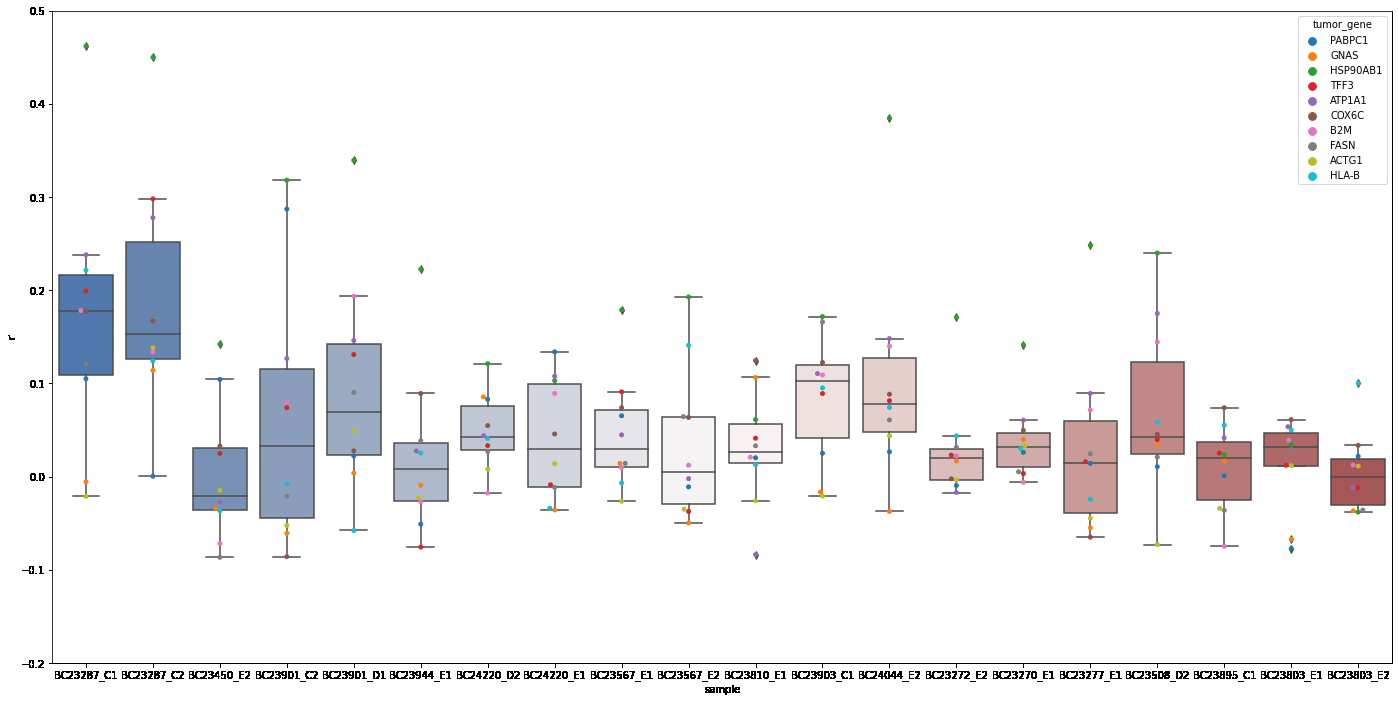

In [10]:
f, ax = plt.subplots(figsize=(24, 12))
sns.boxplot(x="sample", y="r", data=df, palette="vlag")
sns.swarmplot(x="sample", y="r", data=df, hue="tumor_gene")
ax.set_ylim([-0.2, 0.5]) 
plt.show()

In [38]:
OUT_PATH = Path("/clusterdata/uqxtan9/Xiao/STimage/development/Wiener/resnet50_NB_multi_STnet/test_results_top250")
df = pd.read_csv(OUT_PATH/"r2.csv", index_col=0)

In [39]:
df["r"] = df["R2"]
df["top_250"] = df["tumor_gene"]

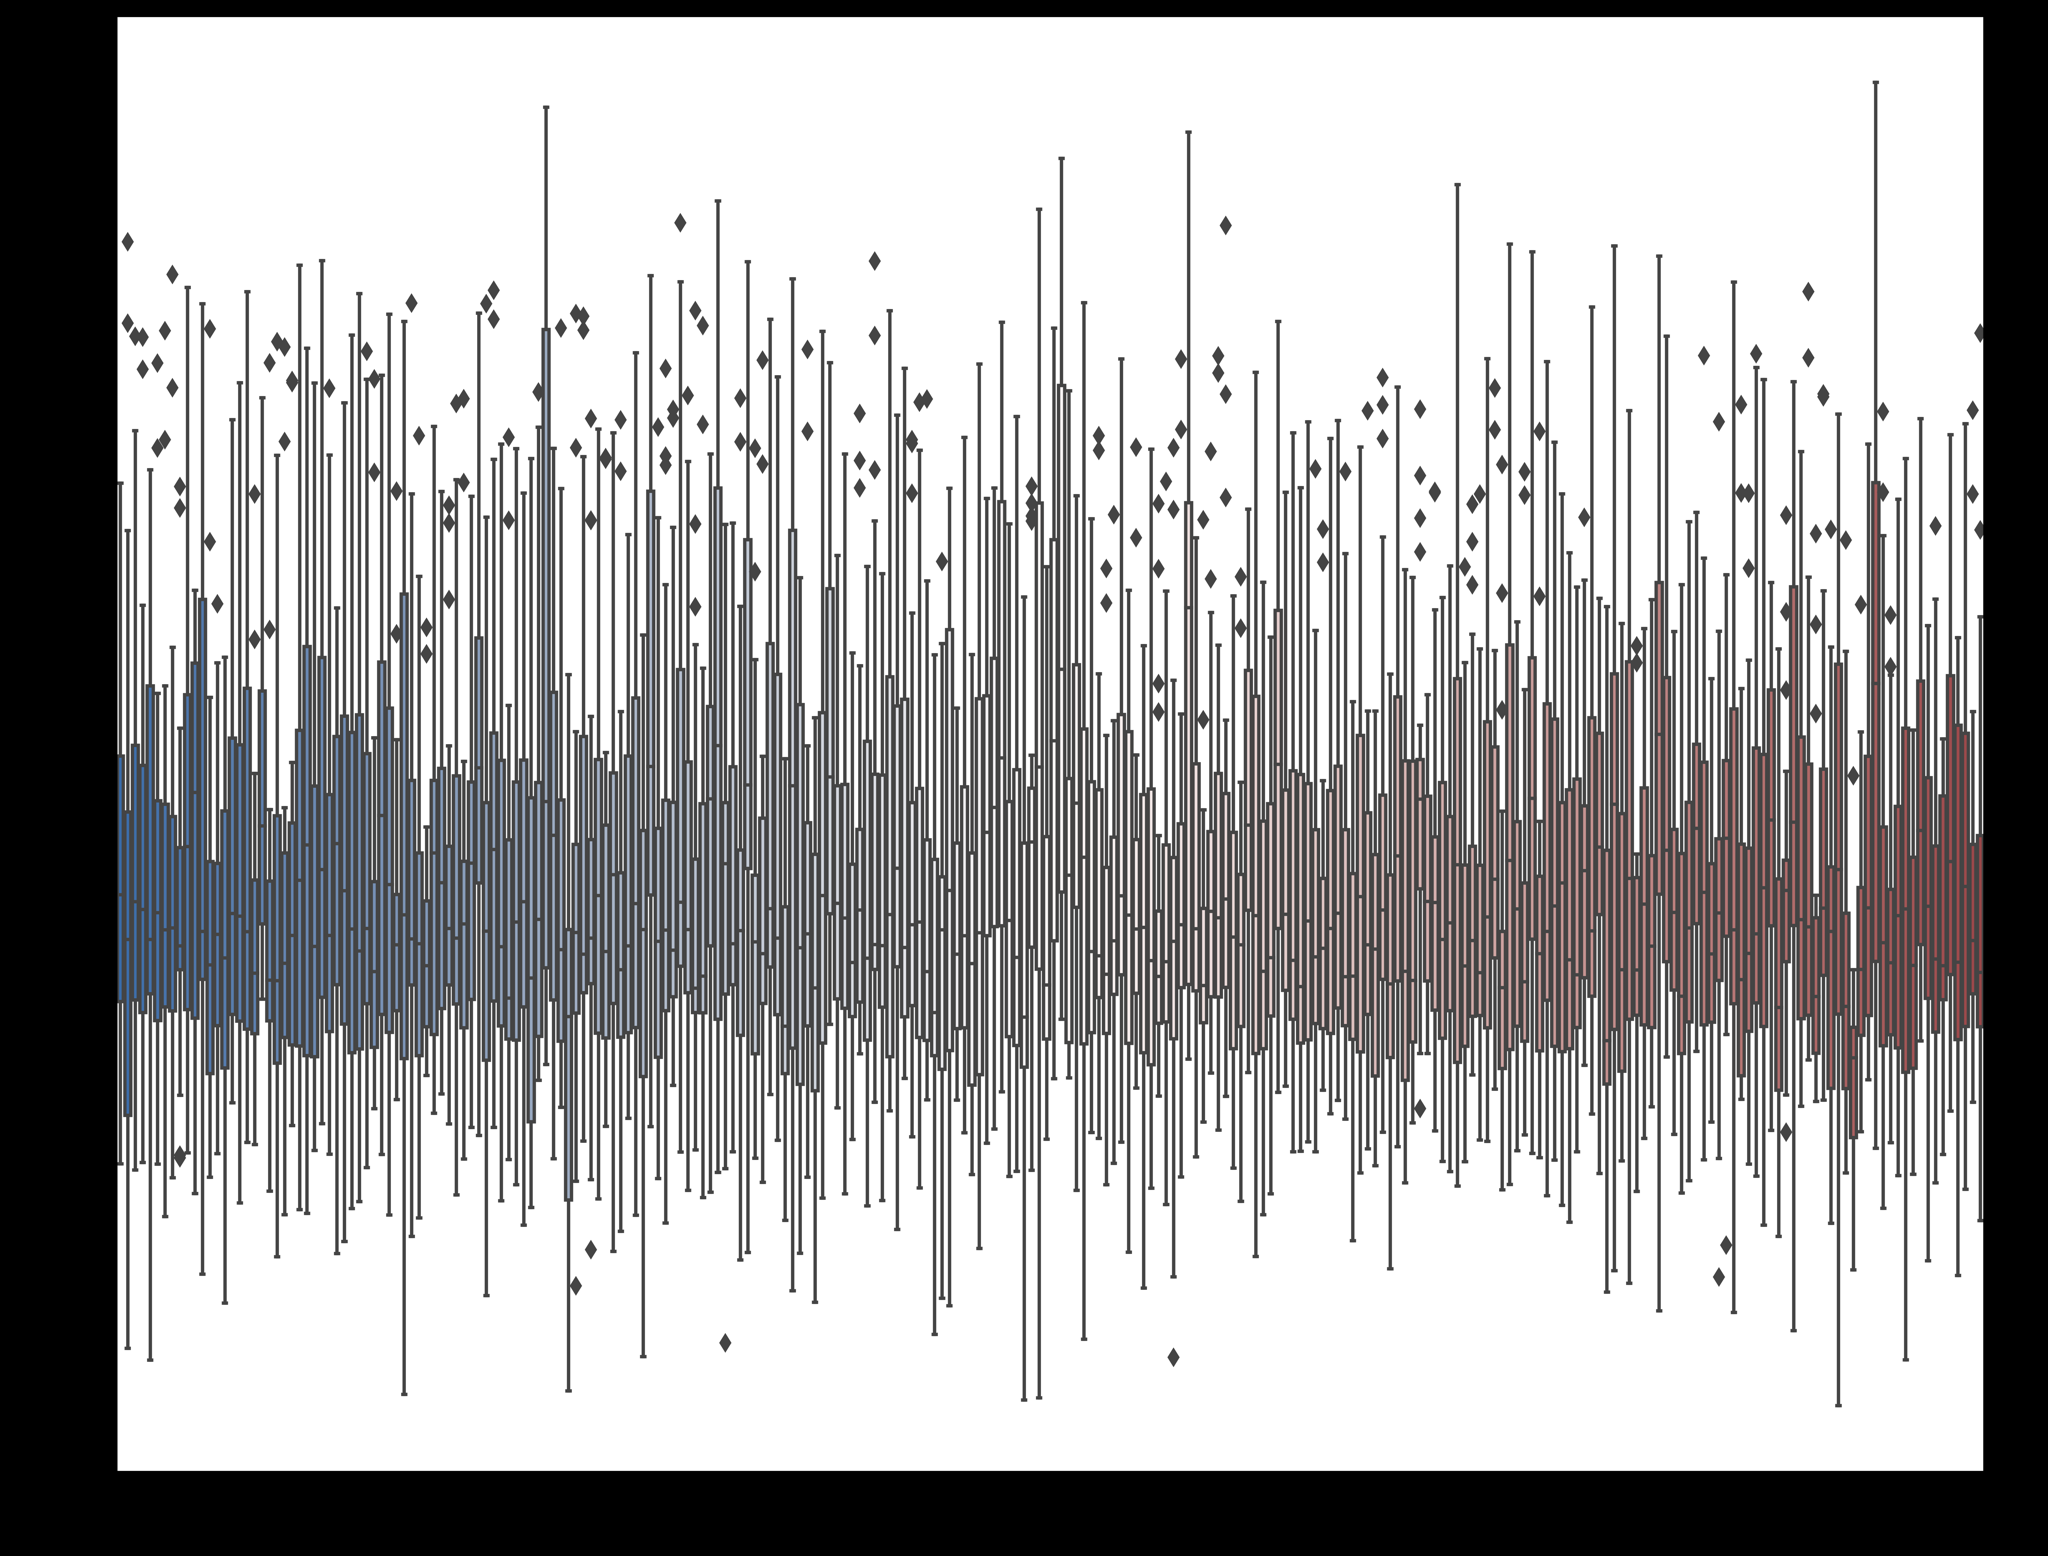

In [40]:
f, ax = plt.subplots(figsize=(15, 12))
sns.boxplot(x="top_250", y="r", data=df, palette="vlag")
# sns.swarmplot(x="tumor_gene", y="r", data=df, hue="sample")
# sns.boxplot(y="r", data=df, palette="vlag")
plt.show()

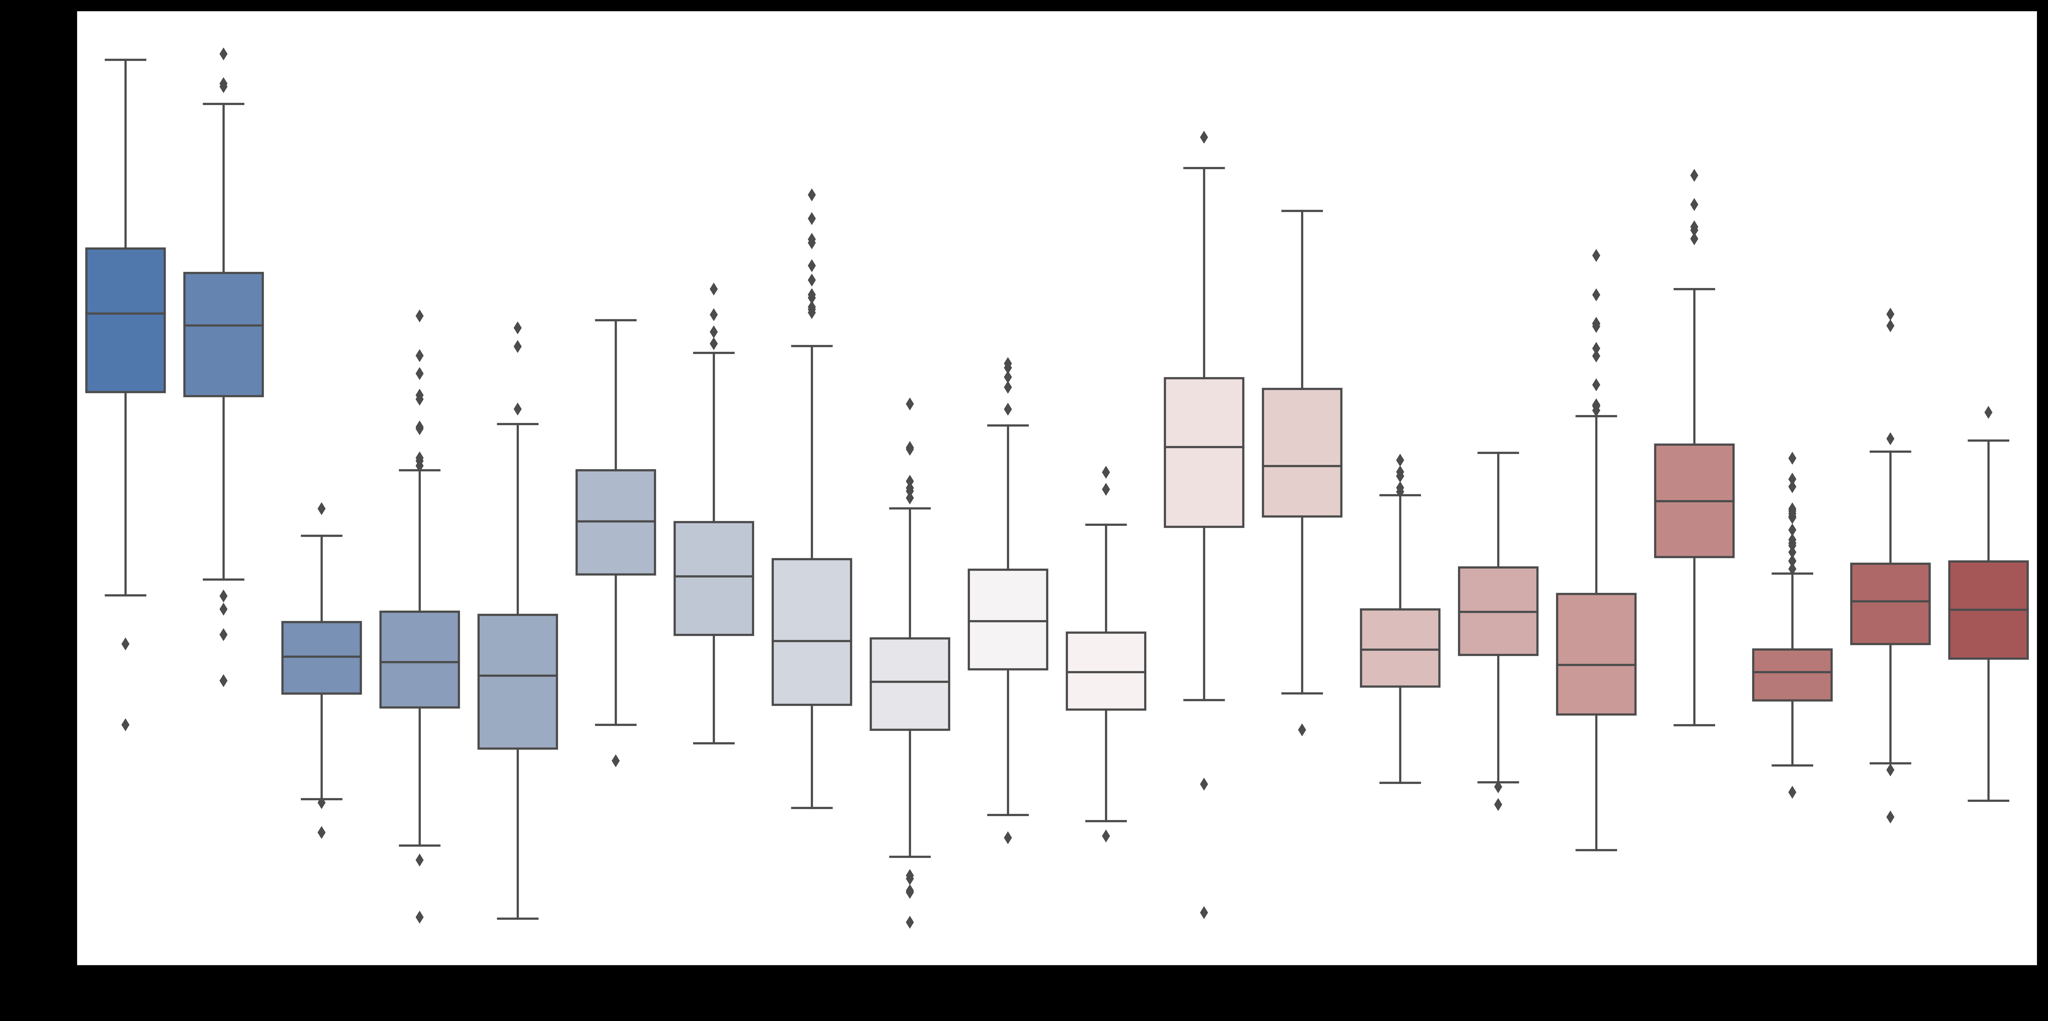

In [41]:
f, ax = plt.subplots(figsize=(24, 12))
sns.boxplot(x="sample", y="r", data=df, palette="vlag")
# sns.swarmplot(x="sample", y="r", data=df, hue="tumor_gene")
plt.show()

In [63]:
len(df["sample"].unique())

20

In [72]:
df_m =df.groupby(["top_250"]).median()#["r"] >= 0

In [73]:
df_p = df_m[df_m["r"] >= 0]

In [74]:
df_p

,R2,r
top_250,,
ADAMTSL1,0.117817,0.117817
AEBP1,0.136436,0.136436
AKAP8L,0.206562,0.206562
ALG6,0.185836,0.185836
AMD1,0.107223,0.107223
...,...,...
ZNF446,0.211600,0.211600
ZNF497,0.161470,0.161470
ZNF641,0.077803,0.077803


In [70]:
df_p["r"].median()

0.1375730828835841

In [71]:
df_p.sort_values("r", ascending=False)["r"][0:102].median()

0.17307458289757008